In [1]:
import numpy as np
import pandas as pd

import datetime

from elo import *

# import nfl_data_py as nfl  # TODO: incorporate API

In [2]:
# Read historical data
df = pd.read_csv('data/archive/spreadspoke_scores.csv')

# Convert schedule to date format (so we can compare dates)
df['schedule_date'] = pd.to_datetime(df['schedule_date']).dt.date
df = df[df['schedule_date'] > datetime.date(1999, 1, 1)]

# Remove team locations (New England Patriots -> Patriots)
df['team_home'] = df['team_home'].str.split(' ').str[-1]
df['team_away'] = df['team_away'].str.split(' ').str[-1]

# Retroactively correct re-named teams
df.replace(to_replace="Team", value="Commanders", inplace=True)  # Washington Football Team -> Washington Commanders
df.replace(to_replace='Redskins', value='Commanders', inplace=True)
df.replace(to_replace='Oilers', value='Titans', inplace=True)

teams = df['team_home'].unique()
assert len(teams) == 32

df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
7084,1999-01-02,1998,Wildcard,True,Cowboys,7,20,Cardinals,DAL,-7.0,42,Texas Stadium,False,NaN,NaN,NaN,NaN
7085,1999-01-02,1998,Wildcard,True,Dolphins,24,17,Bills,MIA,-2.5,43,Sun Life Stadium,False,NaN,NaN,NaN,NaN
7086,1999-01-03,1998,Wildcard,True,Jaguars,25,10,Patriots,JAX,-8.5,41,EverBank Field,False,NaN,NaN,NaN,NaN
7087,1999-01-03,1998,Wildcard,True,49ers,30,27,Packers,SF,-3.0,49.5,Candlestick Park,False,NaN,NaN,NaN,NaN
7088,1999-01-09,1998,Division,True,Falcons,20,18,49ers,ATL,-3.5,53,Georgia Dome,False,72.0,0.0,NaN,indoor


In [3]:
# Initialize Elo
elo = {team : 1500 for team in teams}

In [4]:
# Exploratory data analysis
df[df['spread_favorite'].abs() > 20]

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
9377,2007-11-25,2007,12,False,Patriots,31,28,Eagles,NE,-24.5,51.5,Gillette Stadium,False,36.0,10.0,38.0,NaN
9422,2007-12-16,2007,15,False,Patriots,20,10,Jets,NE,-20.5,41,Gillette Stadium,False,30.0,24.0,79.0,NaN
9441,2007-12-23,2007,16,False,Patriots,28,7,Dolphins,NE,-22.5,45.5,Gillette Stadium,False,39.0,6.0,82.0,NaN
10459,2011-12-04,2011,13,False,Patriots,31,24,Colts,NE,-20.5,48.5,Gillette Stadium,False,54.0,10.0,NaN,NaN
10891,2013-10-13,2013,6,False,Broncos,35,19,Jaguars,DEN,-26.5,52,Sports Authority Field at Mile High,False,59.0,7.0,53.0,NaN
12447,2019-09-22,2019,3,False,Cowboys,31,6,Dolphins,DAL,-21.5,46.5,AT&T Stadium,False,72.0,0.0,NaN,indoor
12453,2019-09-22,2019,3,False,Patriots,30,14,Jets,NE,-21.0,43,Gillette Stadium,False,NaN,NaN,NaN,NaN


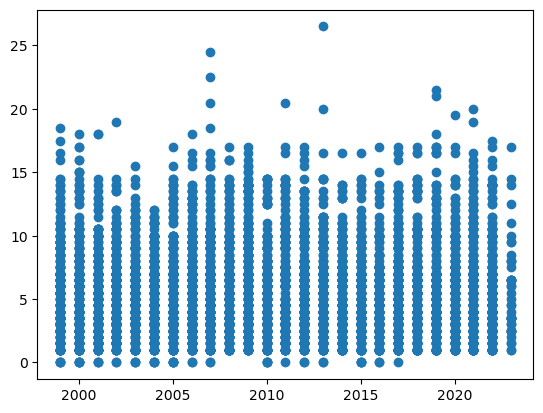

In [15]:
import matplotlib.pyplot as plt

spreads = abs(df['spread_favorite'])
years = pd.to_datetime(df['schedule_date']).dt.year
plt.scatter(years, spreads)

In [18]:
# How many "significant" large spreads have there been?

# np.count_nonzero(spreads >= 21)

df[spreads >= 21]

5